# Лекция 7

# План занятия

1. Форматы моделей (сериализация), оптимизация


## Что такое тестирование производительности?

**Тестирование производительности** — это систематическая проверка, как приложение ведёт себя под разной нагрузкой, с целью выявить узкие места, понять поведение системы и спрогнозировать её устойчивость.

Оно включает в себя несколько подвидов:

- Нагрузочное тестирование (Load Testing) — проверка, как система работает при ожидаемой (или слегка повышенной) нагрузке.

- Стресс-тестирование (Stress Testing) — проверка пределов системы: при каком уровне нагрузки она начинает деградировать.

- Тестирование стабильности (Stability / Endurance / Soak Testing) — запуск системы под умеренной нагрузкой в течение длительного времени (например, ночь или сутки), чтобы выявить утечки памяти и деградацию.

- Тестирование масштабируемости (Scalability Testing) — анализ, как производительность меняется при увеличении ресурсов (CPU, количество реплик и т.д.).

## Что именно мы тестируем?

Важно понимать: нагрузочное тестирование — это не гонка за цифрами. Оно не сводится к запуску 10 000 пользователей на один endpoint вроде /ping и последующей гордости за полученные 150 RPS. Такой подход может красиво смотреться на графике, но не говорит ровным счётом ничего о реальной устойчивости системы.

**Наша цель** — смоделировать поведение живых пользователей. 

## Какие метрики важны?

Чтобы нагрузочное тестирование приносило пользу, важно понимать, что именно нужно измерять. В любом тесте под нагрузкой есть два слоя наблюдения: клиентский и инфраструктурный.

На клиентской стороне — то, что мы видим из Locust: как быстро API отвечает, сколько запросов проходит в секунду, сколько из них завершаются с ошибками. Один из ключевых показателей здесь — время отклика (latency).

Другой важный параметр — RPS (requests per second). Он показывает, сколько запросов система реально обрабатывает при заданной нагрузке. 

С другой стороны, есть инфраструктурные метрики — они дают понимание того, что происходит "внутри" системы. Это, прежде всего, нагрузка на CPU и потребление оперативной памяти. Если при росте RPS CPU сразу уходит в 100%, значит, дальше масштабироваться не получится без оптимизации кода или увеличения ресурсов.

Также важны количество открытых соединений, активность диска (IO), состояние баз данных и кэшей. Например, при пиковых значениях может «задохнуться» Redis, очередь сообщений или файловое хранилище. Бывает, что кэш забит, очередь растёт — а ошибки на клиенте появляются через 2 минуты, когда всё уже упало.

Такие метрики обычно собираются через внешние системы мониторинга: Grafana, Prometheus, Datadog, NewRelic. Они позволяют строить дашборды, отслеживать тренды и мгновенно реагировать на отклонения.

## Технологии

Вот стек инструментов, которые мы будем использовать:

- Python — для написания нагрузочных тестов

- Locust — инструмент симуляции нагрузки

- HTTPX — для отправки запросов к REST API

- Pydantic — для сериализации, десериализации и валидации данных

- Pydantic Settings — для удобной работы с конфигурацией проекта

- Faker — для генерации случайных данных

## Почему именно Locust?

В экосистеме нагрузочного тестирования существует множество инструментов: JMeter, k6, Gatling, Artillery. У каждого — свои сильные стороны. Но если вы работаете с Python, Locust — безусловный лидер. Вот почему:

Нативный Python. Сценарии пишутся на чистом Python, без XML, YAML или UI-конфигов. Это позволяет использовать привычные конструкции языка, логировать, отлаживать, импортировать свои модули и писать тесты с максимальной гибкостью.

Хорошая документация и активное сообщество. Locust активно развивается, регулярно обновляется и имеет большое сообщество разработчиков. На GitHub и StackOverflow легко найти ответы на вопросы, примеры расширений и best practices.

Гибкость и кастомизация. Locust позволяет точно настраивать поведение пользователей: задавать веса задач, использовать SequentialTaskSet, комбинировать сценарии, задавать события на старте и завершении, переопределять поведение на любом уровне.

Поддержка хуков, событий и расширений. Можно использовать event hooks для логирования, метрик, интеграции с внешними системами. Это особенно полезно в связке с CI/CD или системами мониторинга.

## Модели для описания структур данных

Прежде чем работать с API https://api.sampleapis.com/fakebank/accounts, необходимо определить структуру данных, которые мы будем отправлять и получать.

Для этого используем Pydantic, так как он:

- Позволяет автоматически валидировать данные

- Поддерживает сериализацию и десериализацию JSON

- Позволяет использовать встроенные валидаторы, такие как HttpUrl и EmailStr, для проверки корректности данных

- Обеспечивает удобную типизацию

Мы определим:

- `CreateOperationSchema` – модель для создания новой операции

- `UpdateOperationSchema` – модель для обновления данных (используется для PATCH запросов)

- `OperationSchema` – расширенная модель с id, представляющая конечную структуру операции

- `OperationsSchema` – контейнер для списка операций

In [ ]:
{
  "id": 25,
  "debit": 6.99,
  "credit": null,
  "category": "Merchandise",
  "description": "Benderbräu",
  "transactionDate": "2016-02-25"
}

Этот код создается в отдельном файле `/schema/operations.py`

- `CreateOperationSchema` – используется при создании новой операции. Включает поля для суммы списания (debit), суммы зачисления (credit), категории (category), описания (description) и даты (transaction_date).

- `UpdateOperationSchema` – предназначена для PATCH-запросов, где можно передавать только изменяемые поля. Все параметры здесь опциональны, так как частичное обновление не требует передачи всех данных.

- `OperationSchema` – расширенная версия CreateOperationSchema, добавляет поле id, которое присваивается сервером. Используется для представления операции в ответах API.

- `OperationsSchema` – список операций. Наследуется от RootModel, что позволяет работать с массивами объектов в Pydantic.

Почему Pydantic, а не TypedDict или dataclasses?
Pydantic – это лучшее решение для работы с API-данными.

- TypedDict и NamedTuple – подходят больше для аннотаций типов, но не для валидации данных и сериализации.

- dataclasses – могут быть альтернативой, но у них нет встроенной валидации и сериализации JSON. Они работают хорошо в локальных моделях, но для API Pydantic – гораздо удобнее.

Pydantic позволяет автоматически проверять данные, использовать алиасы для полей и работать с JSON без дополнительных преобразований.

## Генерация фейковых данных

Создадим файл: `/tools/fakers.py`

Применение `default_factory`. Каждое поле получает случайное значение при создании экземпляра модели. Пример работы:

In [ ]:
operation = CreateOperationSchema()
print(operation)

## Настройка нагрузочных тестов

Реализуем централизованный подход к управлению настройками для нагрузочных тестов. Это позволит легко изменять параметры без необходимости редактировать код.

В данном примере нам нужно хранить только URL API и таймаут запросов, но в будущем можно расширять этот механизм.

Для управления настройками будем использовать Pydantic Settings — удобную библиотеку, которая позволяет загружать переменные окружения в виде Pydantic-моделей.

Создадим файл: `config.py`

Создадим файл `.env`

Теперь можно просто инициализировать Settings и использовать его:

In [ ]:
settings = Settings()

print(settings.fake_bank_http_client.client_url)  # "https://api.sampleapis.com"
print(settings.fake_bank_http_client.timeout)     # 100

## API клиенты

Для работы с API https://api.sampleapis.com/fakebank/accounts мы используем библиотеку HTTPX. Она современная, производительная и отлично подходит для создания универсального API-клиента. 

Locust, по умолчанию, умеет собирать метрики только со встроенных клиентов. Если мы используем стороннюю библиотеку — такую как HTTPX — то должны вручную передавать информацию о каждом запросе в движок Locust. Именно для этого используются event hooks.

## Как работают event hooks в HTTPX
HTTPX позволяет внедрить свою логику в жизненный цикл запроса с помощью так называемых хуков. Они бывают двух типов: request — вызывается перед отправкой запроса, и response — вызывается после получения ответа. Это удобный механизм, который позволяет реализовать всё: от логирования и трассировки до сбора метрик и интеграции с внешними инструментами.

In [ ]:
def log_request(request):
    print(f"Request event hook: {request.method} {request.url} - Waiting for response")

def log_response(response):
    request = response.request
    print(f"Response event hook: {request.method} {request.url} - Status {response.status_code}")

client = httpx.Client(event_hooks={'request': [log_request], 'response': [log_response]})

Создадим файл `/clients/event_hooks.py`

## Базовый API-клиент и подключение к Locust
На этом этапе у нас есть хуки для интеграции с Locust, и теперь пора построить над ними полноценный фундамент — абстракцию HTTP-клиента, через которую будут идти все запросы. Задача — отделить инфраструктурные детали вроде хуков, маршрутов, конфигурации и логирования от конкретных бизнес-клиентов, таких как OperationsClient. Эта изоляция позволит переиспользовать код, упростит тестирование и повысит читаемость.

Создадим файл `/clients/base_client.py`

Но сам по себе BaseClient не создаёт клиент. Этим занимаются два вспомогательных конструктора — get_http_client и get_locust_http_client. Первый используется, когда нам не нужно собирать метрики (например, в сидинге или обычных автотестах). Второй — когда мы запускаем тест в среде Locust и хотим, чтобы все метрики автоматически отправлялись в HTML-отчёт.

In [ ]:
def get_http_client(config: HTTPClientConfig) -> Client:
    """
    Конструктор базового клиента без хуков.
    Используется в сидинге или вспомогательных модулях.
    """
    logging.getLogger("httpx").setLevel(logging.WARNING)

    return Client(timeout=config.timeout, base_url=config.client_url)

Во втором варианте — get_locust_http_client — мы подключаем хуки, определённые ранее. Один срабатывает до запроса (сохраняет время старта), второй — после получения ответа (считает время, длину и отправляет событие в Locust).

In [ ]:
def get_locust_http_client(config: HTTPClientConfig, environment: Environment) -> Client:
    """
    Конструктор клиента с поддержкой хуков Locust.
    Используется во всех сценариях, где нужно собирать метрики.
    """
    logging.getLogger("httpx").setLevel(logging.WARNING)

    return Client(
        timeout=config.timeout,
        base_url=config.client_url,
        event_hooks={
            "request": [locust_request_event_hook],
            "response": [locust_response_event_hook(environment)]
        }
    )

## Реализация клиента для операций: OperationsClient

После создания базового клиента пришло время реализовать клиентскую обёртку над конкретным REST API. В нашем случае — это OperationsClient, который работает с endpoint’ом /accounts на сервисе fakebank.
Этот клиент строится по принципу двух уровней:
1.	Низкоуровневые методы
2.	Высокоуровневые методы

Создадим файл: `/tools/routes.py`

APIRoutes — перечисление всех возможных эндпоинтов, с которыми будет работать приложение. Это позволяет централизовать и стандартизировать использование адресов.

Создадим файл: `/clients/operations_client.py`

Структура клиента

In [ ]:
class OperationsClient(BaseClient):

OperationsClient наследуется от BaseClient, получая в своё распоряжение стандартные методы get() и post() с поддержкой extensions, конфигурации и хуков Locust.

## Низкоуровневые методы API

In [ ]:
def get_operations_api(self) -> Response:
    return self.get(APIRoutes.OPERATIONS)

Метод отправляет GET-запрос на /accounts и возвращает "сырое" тело ответа. Такой формат пригоден для API-тестов или отладочной работы с данными.

In [ ]:
def get_operation_api(self, operation_id: int) -> Response:
    return self.get(
        f"{APIRoutes.OPERATIONS}/{operation_id}",
        extensions=ClientExtensions(route=f"{APIRoutes.OPERATIONS}/{{operation_id}}")
    )

Этот метод тоже работает на низком уровне, но с одной важной особенностью: он передаёт в extensions шаблон маршрута. Это необходимо, чтобы в метриках Locust не появлялись сотни уникальных строк вроде /accounts/1, /accounts/2, а вместо этого всё агрегировалось под ключом /accounts/{operation_id}

In [ ]:
def create_operation_api(self, operation: CreateOperationSchema) -> Response:
    return self.post(
        APIRoutes.OPERATIONS,
        json=operation.model_dump(mode='json', by_alias=True)
    )

Метод create_operation_api() принимает модель Pydantic и сериализует её в JSON, используя алиасы (например, transaction_date → transactionDate). Возвращается опять же Response.

## Высокоуровневые методы: использование в нагрузке и сидинге

In [ ]:
def get_operations(self) -> OperationsSchema:
    response = self.get_operations_api()
    return OperationsSchema.model_validate_json(response.text)

Метод get_operations() вызывает низкоуровневый API, затем валидирует и преобразует тело ответа в Pydantic-модель OperationsSchema. Это упрощает работу с ответом — теперь мы получаем не JSON или строку, а полноценный Python-объект.

In [ ]:
def get_operation(self, operation_id: int) -> OperationSchema:
    response = self.get_operation_api(operation_id)
    return OperationSchema.model_validate_json(response.text)

Аналогично: сначала вызываем API, затем парсим ответ. Важно, что OperationSchema — это строго типизированная структура. Ошибки при несоответствии типов, форматов или отсутствующих полей будут видны сразу.

In [ ]:
def create_operation(self) -> OperationSchema:
    request = CreateOperationSchema()
    response = self.create_operation_api(request)
    return OperationSchema.model_validate_json(response.text)

Это наиболее «высокоуровневый» метод. Он полностью инкапсулирует всю цепочку: генерацию фейковых данных, сериализацию, отправку запроса и десериализацию ответа. Именно его мы будем вызывать в сценариях Locust и в сидинге, потому что он даёт результат «из коробки» без ручной работы.

## Билдеры клиента
Как и в случае с BaseClient, мы создаём два конструктора клиента — один для обычного использования, другой — для интеграции с Locust.

In [ ]:
def get_operations_client() -> OperationsClient:
    return OperationsClient(client=get_http_client(settings.fake_bank_http_client))

get_operations_client() создаёт клиента без хуков. Это используется, например, в сидинге, когда нам не нужно собирать метрики — а просто сгенерировать или проверить данные.

In [ ]:
def get_operations_locust_client(environment: Environment) -> OperationsClient:
    return OperationsClient(
        client=get_locust_http_client(settings.fake_bank_http_client, environment)
    )

А get_operations_locust_client() используется внутри сценариев Locust. Он создаёт httpx.Client с подключёнными хуками, которые автоматически будут отправлять все метрики и ошибки в HTML-отчёт Locust.

# Лекция 8

## Сидинг

Один из ключевых этапов подготовки к нагрузочному тестированию — это сидинг (от англ. seeding), то есть предварительное наполнение системы нужными данными. Без сидинга любые метрики производительности будут искажены: вы будете тестировать не реальную нагрузку, а начальные этапы использования системы, вроде регистрации и настройки.

Например, если вы хотите проверить, как система обрабатывает массовые операции по уже существующим пользователям — сначала этих пользователей нужно создать. Причём не просто «записать в базу», а подготовить полные, осмысленные данные: активные счета, историю операций, документы и всё, что положено по бизнес-логике.

По сути, сидинг — это создание реалистичного состояния системы до запуска тестов, чтобы эмулировать поведение настоящих пользователей, а не вновь зарегистрированных «болванок».

Почему сидинг нужно делать через API, а не напрямую в базу
Когда речь заходит о создании данных, возникает логичный вопрос: а как именно наполнять систему — через базу или через API?

Простой путь — напрямую вставить данные в базу SQL-скриптами или ORM. Но на практике такой подход опасен, хрупок и практически всегда ведёт к скрытым багам. Поэтому в рамках этого проекта мы используем сидинг через API — и вот почему.

1. API сохраняет бизнес-логику
2. Минимум дублирования и упрощённая поддержка
3. Защита от ошибок и интеграция с логами
4. Масштабируемость

## Почему мы делаем сидинг именно так

Мы хотим, чтобы все данные, участвующие в нагрузочном тесте, были:

- консистентны (например, у операции есть привязанный пользователь и счёт),

- валидны (соответствуют всем правилам API),

- понятны (их можно проследить в логах и при отладке),

- реалистичны (как на боевом окружении).

Поэтому мы будем использовать специальные API-клиенты, которые вызывают реальные методы создания объектов (например, POST /operations), и строим поверх них сидинг-скрипты. Это даёт нам:

- безопасность и контроль,

- гибкость в создании сценариев,

- гарантию, что нагрузочное тестирование идёт на честных, настоящих данных.

Создадим файл `/seeds/schema/plan.py`

- SeedOperationsPlan — описывает, сколько операций нужно сгенерировать. В будущем сюда могут быть добавлены дополнительные параметры: тип операции, сумма, статус и т.д.

- SeedsPlan — корневая схема, которая может включать в себя планы генерации разных сущностей (не только операций, но и пользователей, счетов и т.д.).

Этот план подаётся на вход сидеру и определяет его поведение: сколько данных и какого типа нужно создать.

## Результат сидинга (SeedsResult)

Создадим файл: `/seeds/schema/result.py`

Объяснение:
- SeedOperationResult — результат генерации одной операции. Хранит её ID, который можно использовать при дальнейшем взаимодействии (например, для запроса по ID).
- SeedsResult — агрегирует все созданные данные, сгруппированные по типу. Здесь у нас только operations, но можно добавить users, accounts и т.п.
- Методы get_next_operation() и get_random_operation() позволяют гибко выбирать данные:
1. по порядку (для синхронных сценариев),
2. случайным образом (для имитации разнообразия в нагрузке).

## Почему это удобно

- Явное разделение логики 
- Гибкость и масштабируемость 
- Переиспользуемость 
- Типизация и валидация 

## Реализация сидинг-билдера

Теперь, когда мы определили, что сидинг нужно делать именно через API, давайте реализуем простой, но расширяемый сидинг-билдер. Его задача — получить на вход план сидинга и вернуть результат, пригодный для использования в нагрузочных сценариях.

В нашей системе мы хотим, чтобы сидер:

- создавал заданное количество операций через API,
- возвращал ссылки на созданные сущности (например, ID операций),
- работал через универсальные Pydantic-схемы SeedsPlan и SeedsResult,
- мог быть расширен в будущем — например, для создания пользователей, счетов, документов и так далее.


Создадим файл: `/seeds/builder.py`

## Сохраняем результат сидинга
После выполнения сидинга у нас на руках оказывается структура SeedsResult, в которой собраны все созданные объекты (например, operation_id операций). Эти данные могут понадобиться позже:

- для запуска нагрузочного сценария,

- для анализа проблем,

- для отладки,

- для повторного использования,

- или для CI/CD пайплайна.

Чтобы не терять эти данные, мы сохраняем результат в файл.

Создадим файл: `/seeds/dumps.py`

Такой подход даёт сразу несколько преимуществ:

- Повторное использование. 
- Отладка и воспроизводимость.
- Поддержка CI/CD.
- Масштабирование. 

## Базовая архитектура нагрузочных сценариев: User, TaskSet, SequentialTaskSet

Теперь, когда у нас есть подготовленные тестовые данные (сидинг), мы можем перейти к следующему важному этапу — изучению архитектуры нагрузочных сценариев. В этом блоке мы не будем реализовывать полноценные сценарии, а сосредоточимся на базовых строительных блоках, из которых они в дальнейшем будут собираться:

- виртуальные пользователи (User),

- наборы задач (TaskSet),

- последовательные сценарии (SequentialTaskSet).

Базовый виртуальный пользователь
Чтобы не повторять одни и те же настройки в каждом сценарии, мы создадим базовый класс пользователя, от которого будут наследоваться все остальные. Он задаёт:

базовый host (адрес сервиса по умолчанию),

стратегию ожидания между задачами (wait_time),

и помечается как абстрактный, чтобы не запускался напрямую.

Создадим файл: `/tools/locust/user.py`

## Зачем нужен абстрактный пользователь?

Locust ищет все классы, унаследованные от User, и считает их «реальными пользователями», которых нужно запускать. Но в нашем случае мы хотим использовать BaseLocustUser только как базу для других классов, чтобы переиспользовать общее поведение и настройки.

Поэтому мы выставляем:

In [ ]:
abstract = True

Это позволяет избежать случайного запуска базового класса и делает архитектуру чище.

Почему host = "localhost" — это заглушка?

Locust требует, чтобы у каждого User было указано поле host. Обычно это базовый URL, к которому будут отправляться запросы через встроенный HTTP-клиент (например, HttpUser). Но в нашем случае:

- Мы не используем HttpUser, а базируемся на обычном User

- Все запросы отправляются через кастомные httpx-клиенты, у которых base_url задаётся отдельно

- Поэтому значение host никак не влияет на выполнение сценария, но его необходимо задать, чтобы избежать ошибки запуска

## Базовые TaskSet и SequentialTaskSet

После того как мы определили абстрактного пользователя (BaseLocustUser), следующим шагом будет реализация базовых TaskSet-классов, в которых мы будем описывать сценарии поведения пользователей.

В Locust существуют два базовых типа TaskSet:
| Тип | Особенность |
| --- | --- |
| **TaskSet** | Задачи (tasks) выполняются в произвольном порядке, с учётом веса задач |
| **SequentialTaskSet** | Задачи выполняются строго последовательно, сверху вниз |



Создадим файл: `/tools/locust/task_set.py`

## Как это использовать в реальных сценариях?
Если вы хотите написать последовательный сценарий из нескольких шагов, создайте класс, унаследованный от BaseLocustSequentialTaskSet, и опишите задачи в нужном порядке с помощью @task.

Если сценарий более свободный и пользователь выполняет действия случайно, создайте класс от BaseLocustTaskSet, добавьте задачи с разным weight — и Locust сам будет выбирать порядок выполнения.

## Нагрузочные сценарии

Давайте реализуем два типовых сценария нагрузки:

- один — с созданием данных на лету,

- второй — с использованием заранее подготовленных данных через сидинг.

## Сценарий без сидинга: создание операции, просмотр списка и деталей

Создадим файл `/scenarios/get_operation_without_seeds/scenario.py`

## Почему используется SequentialTaskSet, а не TaskSet

Мы намеренно используем SequentialTaskSet, чтобы гарантировать порядок выполнения задач:

1. сначала создаётся операция,

2. затем вызывается метод получения списка операций,

3. затем — получение конкретной операции.



## Почему мы не задаём веса задач (@task(n))

Во многих сценариях веса задач указываются для моделирования вероятностей — например, операция "открыть документ" может встречаться чаще, чем "удалить аккаунт".

В данном случае мы используем SequentialTaskSet, а значит порядок жёстко зафиксирован и вес не играет никакой роли. Все задачи выполняются ровно один раз в том порядке, в котором они описаны. Поэтому декораторы @task без аргументов здесь абсолютно корректны.

## Зачем проверка if not self.operation

Операция создаётся через внешний API. Это значит, что:

- сервис может временно недоступен (5xx),

- включена защита от нагрузки (429),

- произошла ошибка сериализации, валидации или другая ошибка бизнес-логики.

In [ ]:
if not self.operation:
    return

## Конфигурация запуска

Создадим файл: `/scenarios/get_operation_without_seeds/v1.0.conf`

## Почему нагрузка скромная?

Обратите внимание: в конфигурации указан умеренный профиль нагрузки — всего 20 пользователей, скорость запуска 2 пользователя в секунду, продолжительность 30 секунд. Это не случайность.

Мы работаем с тестовым API https://api.sampleapis.com/fakebank/accounts, у которого установлен рейт-лимит. При избыточной нагрузке сервис начинает возвращать ответы с кодом 429 Too Many Requests. Такие ошибки искажают результат тестирования и мешают сосредоточиться на логике сценария.

Поэтому:

- мы сознательно ограничиваем количество пользователей;

- не стремимся "положить" сервис;

- и соблюдаем культуру инженерного тестирования — тестируем не ради нагрузки, а ради понимания поведения системы под управляемым профилем.

## Сценарий с использованием сидинга

В отличие от предыдущего сценария, где пользователь сначала создавал данные сам, здесь мы заранее подготовим всё необходимое — операции будут созданы ещё до запуска теста, и виртуальные пользователи будут использовать уже готовые данные.

Зачем это нужно?

- Это ускоряет разгон нагрузки, так как пользователям не нужно тратить время на создание данных.

- Это исключает дополнительную нагрузку на систему от действий, которые не являются основной целью теста (например, регистрация или генерация операций).

- Это позволяет протестировать сценарии "существующих пользователей", что ближе к продакшен-реальности.

Создадим файл: `/scenarios/get_operation_with_seeds/scenario.py`

## Почему используется TaskSet, а не SequentialTaskSet

В этом сценарии порядок выполнения действий не важен:

- пользователь может сначала открыть список операций,

- а потом выбрать одну из них (или наоборот).

## Как работают веса задач: @task(n)

В TaskSet веса задач управляют частотой вызовов:

- @task(1) означает: задача должна выполняться один раз из всех доступных вызовов.

- @task(3) означает: задача должна выполняться в три раза чаще, чем задача с весом 1.

То есть в данном случае распределение будет:

- get_operations — 25% (1 из 4),

- get_operation — 75% (3 из 4).

Это поведение задаёт соотношение реальных сценариев: пользователь чаще открывает конкретные детали операции, чем весь список.

## Использование событий Locust (event hooks)

Ключевой особенностью этого сценария является использование событийной системы Locust, а именно хука @events.init.add_listener:

In [ ]:
@events.init.add_listener
def init(environment: Environment, **kwargs):
    ...

Этот хук срабатывает один раз перед запуском теста, сразу после инициализации окружения Locust. Именно в нём мы и выполняем сидинг:

- Получаем сидинг-билдер через get_seeds_builder().

- Создаём 20 операций с помощью builder.build(...).

- Сохраняем результат сидинга в файл get_operations_with_seeds_seeds.json.

- Передаём результат в environment.seeds, чтобы он стал доступен всем пользователям.

## Сам сценарий

In [ ]:
class GetOperationTaskSet(BaseLocustTaskSet):
    seed_operation: SeedOperationResult

    def on_start(self) -> None:
        super().on_start()
        self.seed_operation = self.user.environment.seeds.get_random_operation()

В методе on_start каждый виртуальный пользователь получает одну случайную операцию из общего результата сидинга. Далее он будет с ней работать.

In [ ]:
@task(1)
def get_operations(self):
    self.operations_client.get_operations()

@task(3)
def get_operation(self):
    self.operations_client.get_operation(self.seed_operation.operation_id)

Пользователь:

- сначала получает список всех операций (не обязательно, но имитирует поведение UI),

- затем делает детальный запрос по своей конкретной операции.

Зачем мы сохраняем результат сидинга?

In [ ]:
save_seeds_result(result=result, scenario="get_operations_with_seeds")

Мы сохраняем результат в файл, потому что:

-  это позволяет повторно использовать данные без повторного сидинга;

- это даёт возможность проанализировать сидированные данные;

- это удобно для отладки: можно посмотреть, какие ID операций были созданы, если что-то пошло не так.

## Конфигурация запуска
Создадим файл `/scenarios/get_operation_with_seeds/v1.0.conf`

Эта конфигурация повторяет структуру первого сценария. Используется умеренный профиль нагрузки, так как:

- стенд учебный, и у него есть ограничение на количество запросов (rate limit),

- мы хотим избежать 429 Too Many Requests,

- нам важно сохранить чистоту метрик, не перегружая систему искусственно.

## Запуск на CI/CD
Настроим workflow-файл для автоматического запуска нагрузочных тестов в GitHub Actions, генерации Locust HTML-отчета с сохранением истории и публикации его на GitHub Pages.

Создададим файл: `/.github/workflows/load-tests.yaml`

Ссылки на документацию для всех использованных actions можно найти ниже:

- [GitHub Actions Marketplace](https://github.com/marketplace?type=actions)

- [GitHub Action для установки python](https://github.com/actions/setup-python)

- [GitHub Action для извлечения кода репозитория](https://github.com/actions/checkout)

- [GitHub Action для загрузки артефактов](https://github.com/actions/upload-artifact)

- [GitHub Action для скачивания артефактов](https://github.com/actions/download-artifact)

- [GitHubActions для публикации на GitHub Pages](https://github.com/peaceiris/actions-gh-pages)

## Разрешения для Workflow

Если сейчас запустить нагрузочные тесты на GitHub Actions то, будет ошибка, говорящая о том, что у github token из workflow по умолчанию нет прав на записть в репзоиторий

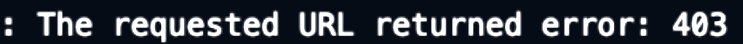

Для исправления этой ошибки необходимо вручную изменить настройки прав workflow:

1. Откройте вкладку Settings в репозитории GitHub.

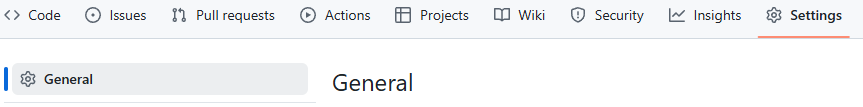

2. Перейдите в раздел Actions → General.

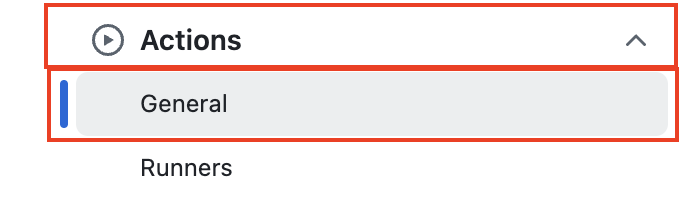

3. Прокрутите страницу вниз до блока Workflow permissions.

4. Выберите опцию Read and write permissions.

5. Нажмите кнопку Save для сохранения изменений.

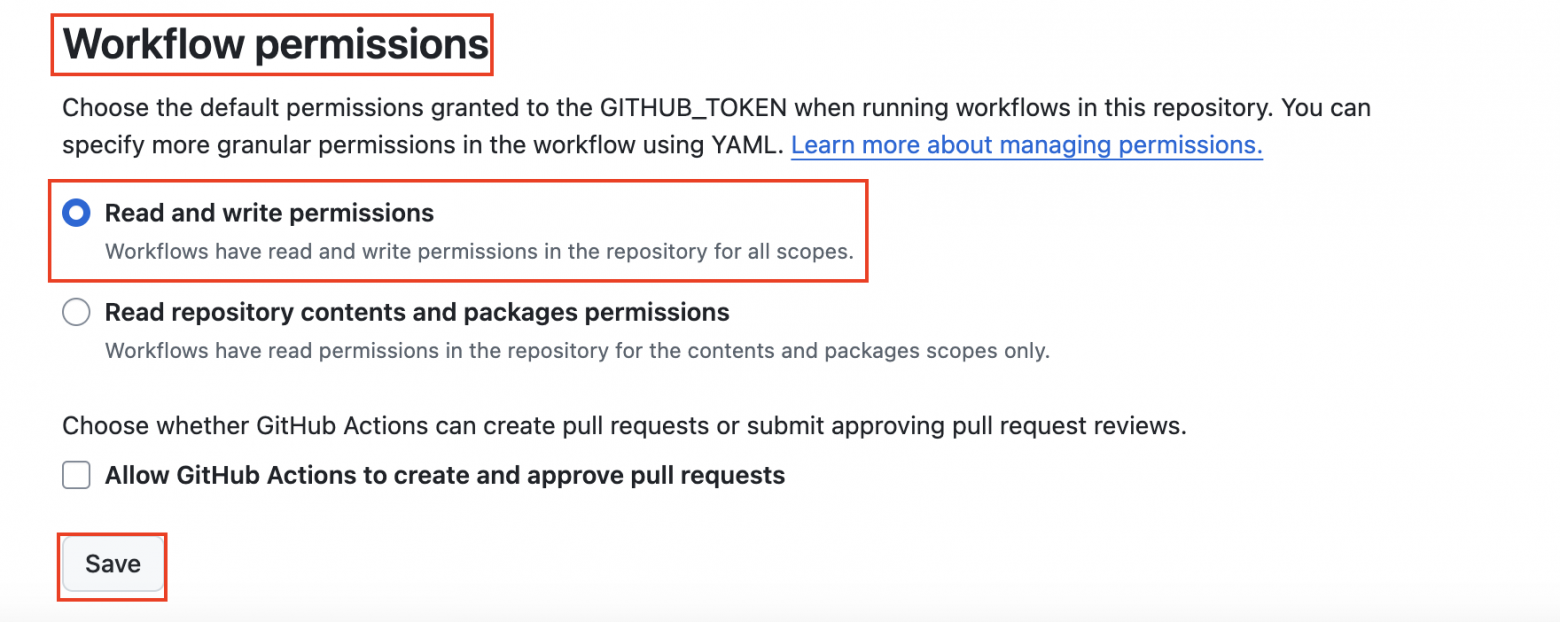

После выполнения этих шагов можно отправить код с нагрузочными тестами в удалённый репозиторий.


## Запуск нагрузочного теста вручную через GitHub Actions

После того как вы настроили workflow-файл и закоммитили его в репозиторий, вы можете запускать нагрузочные тесты в один клик прямо из интерфейса GitHub.

1. Перейдите на вкладку Actions вашего репозитория — она находится в верхнем меню.

2. В списке workflow-ов слева выберите Load Tests.

3. Нажмите на кнопку Run workflow в правом верхнем углу.

4. В выпадающем списке Locust config file выберите нужный .conf-файл — например, ./scenarios/get_operation_with_seeds/v1.0.conf. Это определит, какой именно сценарий нагрузки будет выполнен.

5. Нажмите зелёную кнопку Run workflow.

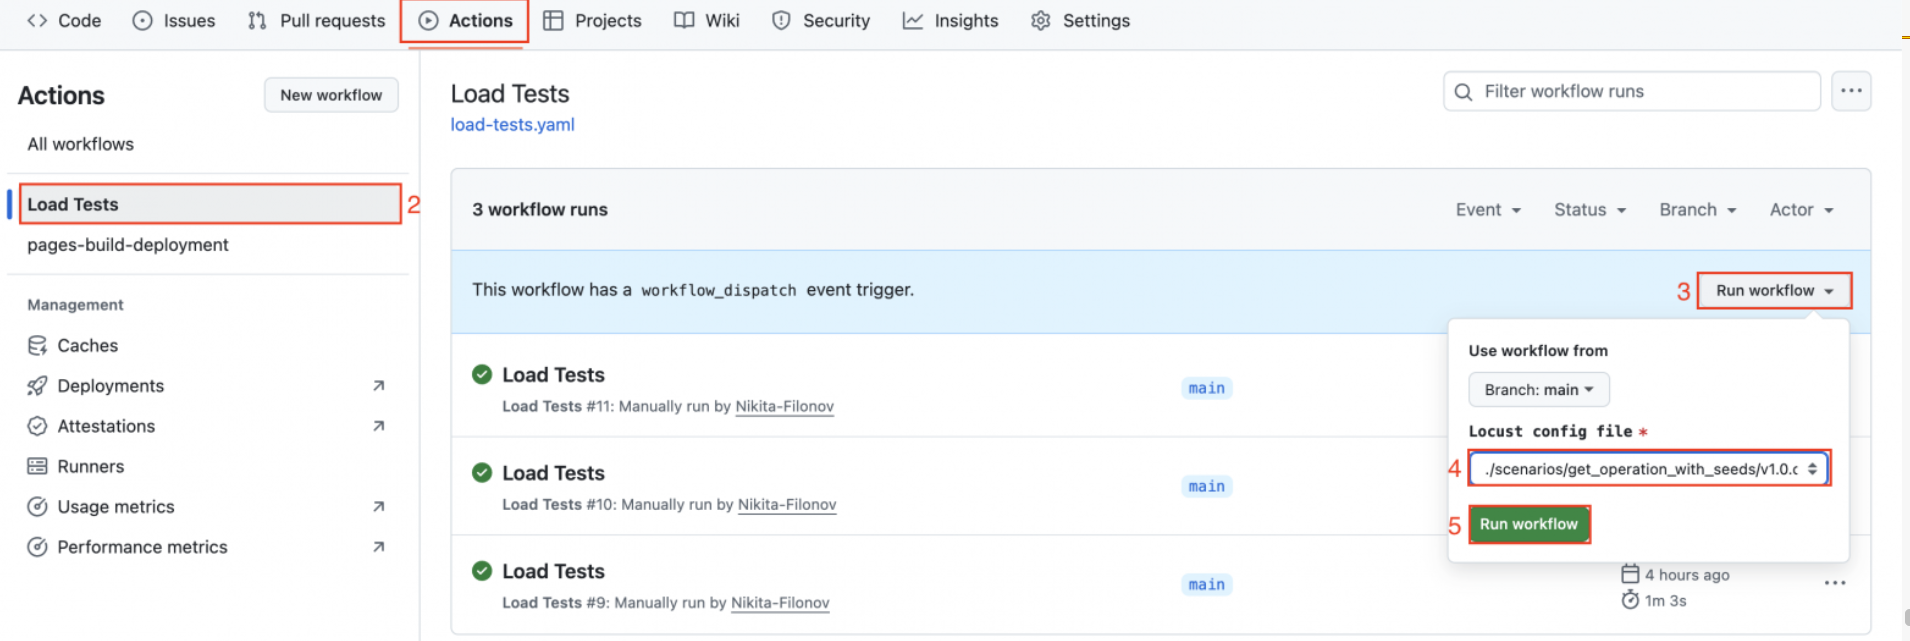

## Проверка настроек GitHub Pages

Если workflow pages build and deployment не запустился, необходимо проверить настройки GitHub Pages:

1. Откройте вкладку Settings в репозитории.

2. Перейдите в раздел Pages → Build and deployment.

3. Убедитесь, что параметры соответствуют настройкам на скриншоте ниже.

На этой же странице будет отображаться виджет со ссылкой на опубликованный Allure-отчёт.

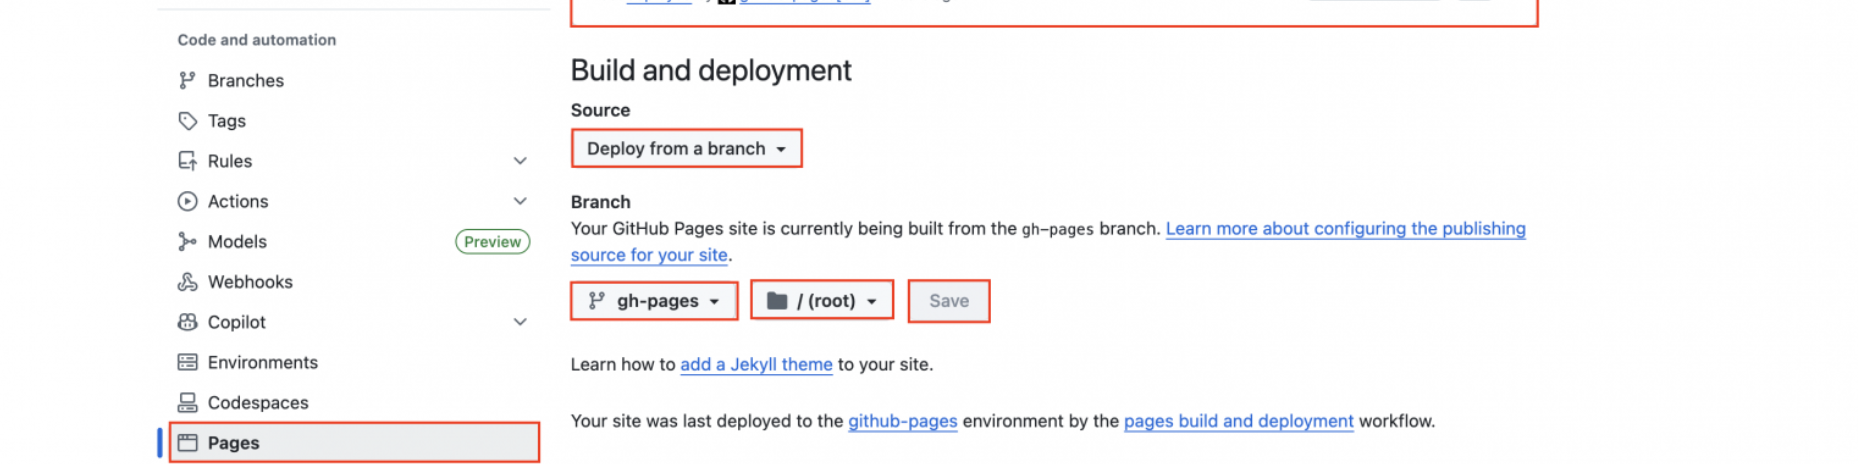

## Доступ к Locust HTML-отчётам

- Каждый отчёт публикуется на GitHub Pages с уникальным идентификатором run id, в котором он был сгенерирован.

- Все сгенерированные Locust HTML-отчёты также можно найти в ветке gh-pages.

- Перейдя по ссылке на GitHub Pages, можно открыть сгенерированный Locust HTML-отчёт с результатами нагрузочного тестирования.

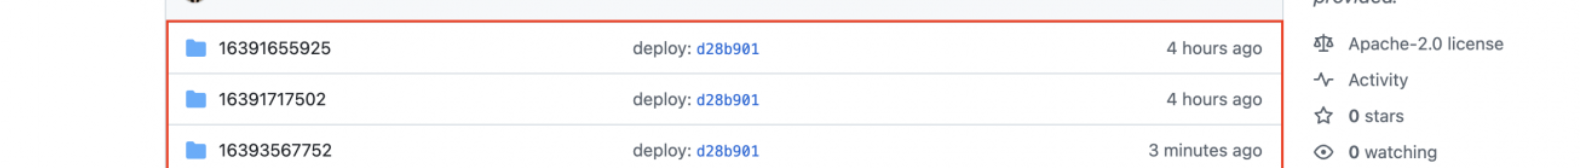

По итогу, после корректной настройки, при каждом новом запуске нагрузочных тестов Locust HTML-отчёт будет автоматически сохраняться в ветку gh-pages и публиковаться на GitHub Pages.

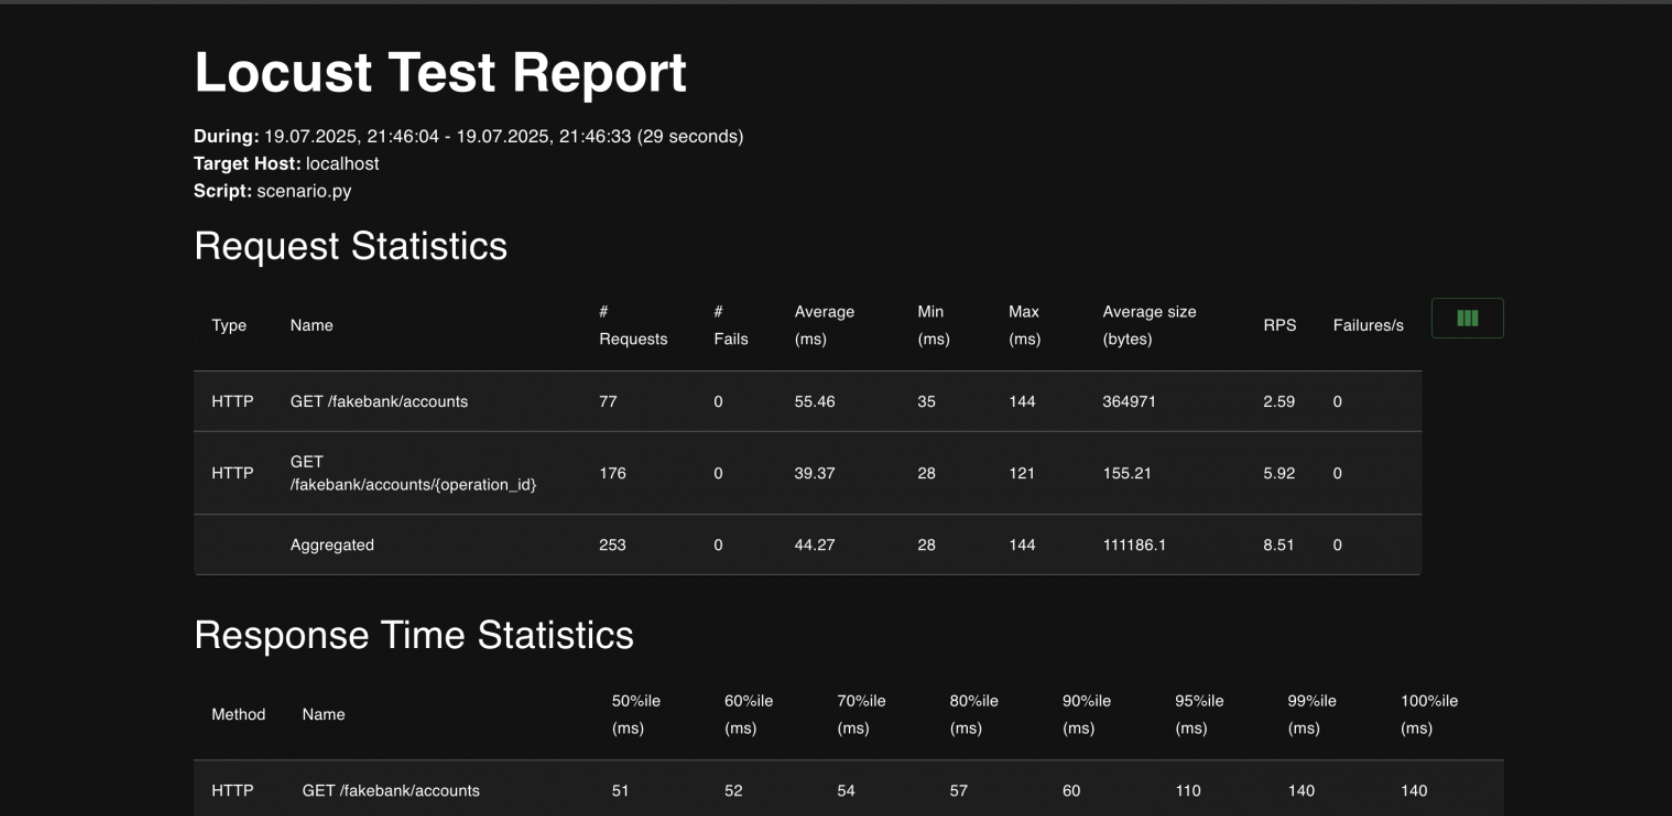